In [ ]:
import os
import mpld3
import numpy as np
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    AngleAxis,
    DiagramBuilder,
    Integrator,
    JacobianWrtVariable,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    Parser,
    PiecewisePolynomial,
    PiecewisePose,
    Quaternion,
    Rgba,
    RigidTransform,
    RotationMatrix,
    SceneGraph,
    Simulator,
    StartMeshcat,
    TrajectorySource,
)
from pydrake.common import temp_directory
from pydrake.visualization import ModelVisualizer
from pydrake.geometry import Box
from pydrake.multibody.tree import SpatialInertia, UnitInertia, RigidBody

from manipulation import running_as_notebook, create_sdf_from_mesh
from manipulation.utils import RenderDiagram
from manipulation.station import MakeHardwareStation, load_scenario


if running_as_notebook:
    mpld3.enable_notebook()

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://df10144e-981b-4bcc-8f1f-bfdbe929934e.deepnoteproject.com/7000/


### Build Table

In [ ]:
# Create a Drake temporary directory to store files.
# Note: this tutorial will create a temporary file (table_top.sdf)
# in the `/tmp/robotlocomotion_drake_xxxxxx` directory.
temp_dir = temp_directory()

# Create a table top SDFormat model.
table_top_sdf_file = os.path.join(temp_dir, "table_top.sdf")
table_top_sdf = """<?xml version="1.0"?>
<sdf version="1.7">

  <model name="table_top">
    <link name="table_top_link">
      <inertial>
        <mass>18.70</mass>
        <inertia>
          <ixx>0.79</ixx>
          <ixy>0</ixy>
          <ixz>0</ixz>
          <iyy>0.53</iyy>
          <iyz>0</iyz>
          <izz>1.2</izz>
        </inertia>
      </inertial>
    <visual name="bottom">
        <pose>-0.22 -0.6 0.67 0 0 0</pose>
        <geometry>
          <box>
            <size>3.0 1.0 0.015</size>
          </box>
        </geometry>
        <material>
          <diffuse>0.5 0.25 0.0 1.0</diffuse>
        </material>
      </visual>
      <collision name="bottom">
        <pose>-0.22 -0.6 0.67 0 0 0</pose>
        <geometry>
          <box>
            <size>3.0 1.0 0.015</size>
          </box>
        </geometry>
        <drake:proximity_properties>
          <drake:compliant_hydroelastic/>
          <drake:hydroelastic_modulus>1.0e6</drake:hydroelastic_modulus>
        </drake:proximity_properties>
      </collision>
    </link>
    <frame name="table_top_center">
      <pose relative_to="table_top_link">0 0 0.47 0 0 0</pose>
    </frame>
  </model>
</sdf>

"""

with open(table_top_sdf_file, "w") as f:
    f.write(table_top_sdf)

## Function to Make the Frames that the Gripper will Visit

In [ ]:
def MakeGripperFramesGuitarHeroTest(X_WG, X_WO):
    """
    Takes a partial specification with X_G["initial"] and X_O["initial"] and
    X_0["goal"], and returns a X_G and times with all of the
    frames populated.
    """
    # Define the gripper pose relative to a button when pressing.
    p_GpressO = [0, 0.12, 0]
    R_GpressO = RotationMatrix.MakeXRotation(
        np.pi / 2.0
    ) @ RotationMatrix.MakeZRotation(np.pi / 2.0)
    X_GpressO = RigidTransform(R_GpressO, p_GpressO)
    X_OGpress = X_GpressO.inverse()
    # pregrasp is negative y in the gripper frame (see the figure!).
    X_GpressGprepress = RigidTransform([0, -0.08, 0])

    X_WG["press1"] = X_WO["button1"] @ X_OGpress
    X_WG["press12"] = X_WO["button12"] @ X_OGpress
    X_WG["press2"] = X_WO["button2"] @ X_OGpress
    X_WG["press23"] = X_WO["button23"] @ X_OGpress
    X_WG["press3"] = X_WO["button3"] @ X_OGpress
    X_WG["press34"] = X_WO["button34"] @ X_OGpress
    X_WG["press4"] = X_WO["button4"] @ X_OGpress
    X_WG["press45"] = X_WO["button45"] @ X_OGpress
    X_WG["press5"] = X_WO["button5"] @ X_OGpress
    X_WG["press13"] = X_WG["press2"]
    X_WG["press24"] = X_WG["press3"]
    X_WG["press35"] = X_WG["press4"]
    X_WG["prepress1"] = X_WG["press1"] @ X_GpressGprepress
    X_WG["prepress12"] = X_WG["press12"] @ X_GpressGprepress
    X_WG["prepress2"] = X_WG["press2"] @ X_GpressGprepress
    X_WG["prepress23"] = X_WG["press23"] @ X_GpressGprepress
    X_WG["prepress3"] = X_WG["press3"] @ X_GpressGprepress
    X_WG["prepress34"] = X_WG["press34"] @ X_GpressGprepress
    X_WG["prepress4"] = X_WG["press4"] @ X_GpressGprepress
    X_WG["prepress45"] = X_WG["press45"] @ X_GpressGprepress
    X_WG["prepress5"] = X_WG["press5"] @ X_GpressGprepress
    X_WG["prepress13"] = X_WG["prepress2"]
    X_WG["prepress24"] = X_WG["prepress3"]
    X_WG["prepress35"] = X_WG["prepress4"]

    # Now let's set the timing
    times = {"initial": 0}
    times["prepress1"] = times["initial"] + 0.5
    times["press1"] = times["prepress1"] + 0.5
    times["postpress1"] = times["press1"] + 0.5
    X_WG["postpress1"] = X_WG["prepress1"]

    times["prepress12"] = times["postpress1"] + 0.5
    times["press12"] = times["prepress12"] + 0.5
    times["postpress12"] = times["press12"] + 0.5
    X_WG["postpress12"] = X_WG["prepress12"]

    times["prepress2"] = times["postpress12"] + 0.5
    times["press2"] = times["prepress2"] + 0.5
    times["postpress2"] = times["press2"] + 0.5
    X_WG["postpress2"] = X_WG["prepress2"]

    times["prepress23"] = times["postpress2"] + 0.5
    times["press23"] = times["prepress23"] + 0.5
    times["postpress23"] = times["press23"] + 0.5
    X_WG["postpress23"] = X_WG["prepress23"]

    times["prepress3"] = times["postpress23"] + 0.5
    times["press3"] = times["prepress3"] + 0.5
    times["postpress3"] = times["press3"] + 0.5
    X_WG["postpress3"] = X_WG["prepress3"]

    times["prepress34"] = times["postpress3"] + 0.5
    times["press34"] = times["prepress34"] + 0.5
    times["postpress34"] = times["press34"] + 0.5
    X_WG["postpress34"] = X_WG["prepress34"]

    times["prepress4"] = times["postpress34"] + 0.5
    times["press4"] = times["prepress4"] + 0.5
    times["postpress4"] = times["press4"] + 0.5
    X_WG["postpress4"] = X_WG["prepress4"]

    times["prepress45"] = times["postpress4"] + 0.5
    times["press45"] = times["prepress45"] + 0.5
    times["postpress45"] = times["press45"] + 0.5
    X_WG["postpress45"] = X_WG["prepress45"]

    times["prepress5"] = times["postpress45"] + 0.5
    times["press5"] = times["prepress5"] + 0.5
    times["postpress5"] = times["press5"] + 0.5
    X_WG["postpress5"] = X_WG["prepress5"]

    times["prepress13"] = times["postpress5"] + 0.5
    times["press13"] = times["prepress13"] + 0.5
    times["postpress13"] = times["press13"] + 0.5
    X_WG["postpress13"] = X_WG["prepress13"]

    times["prepress24"] = times["postpress13"] + 0.5
    times["press24"] = times["prepress24"] + 0.5
    times["postpress24"] = times["press24"] + 0.5
    X_WG["postpress24"] = X_WG["prepress24"]

    times["prepress35"] = times["postpress24"] + 0.5
    times["press35"] = times["prepress35"] + 0.5
    times["postpress35"] = times["press35"] + 0.5
    X_WG["postpress35"] = X_WG["prepress35"]

    # X_WG is a dictionary of frames for the gripper, times is a dictionary of times for those frames
    return X_WG, times

def MakeGripperFramesGuitarHero(X_WG, X_WO, notes):
    """
    Same as test, but times dictionary maps frames to lists of times
    Inputs:
        X_WG: dictionary that should only include initial frame of the gripper
        X_WO: dictionary that contains poses of important objects in the world (buttons and between buttons)
        notes: list ex. [(1,1,3),(45,5,1),...] a note has (button, start time, duration)
    """
    # Define the gripper pose relative to a button when pressing.
    p_GpressO = [0, 0.13, 0.02]
    R_GpressO = RotationMatrix.MakeXRotation(
        np.pi / 2.0
    ) @ RotationMatrix.MakeZRotation(np.pi / 2.0)
    X_GpressO = RigidTransform(R_GpressO, p_GpressO)
    X_OGpress = X_GpressO.inverse()
    # pregrasp is negative y in the gripper frame (see the figure!).
    X_GpressGprepress = RigidTransform([0, -0.05, 0])

    X_WG["press1"] = X_WO["button1"] @ X_OGpress
    X_WG["press12"] = X_WO["button12"] @ X_OGpress
    X_WG["press2"] = X_WO["button2"] @ X_OGpress
    X_WG["press23"] = X_WO["button23"] @ X_OGpress
    X_WG["press3"] = X_WO["button3"] @ X_OGpress
    X_WG["press34"] = X_WO["button34"] @ X_OGpress
    X_WG["press4"] = X_WO["button4"] @ X_OGpress
    X_WG["press45"] = X_WO["button45"] @ X_OGpress
    X_WG["press5"] = X_WO["button5"] @ X_OGpress
    X_WG["press13"] = X_WG["press2"]
    X_WG["press24"] = X_WG["press3"]
    X_WG["press35"] = X_WG["press4"]

    X_WG["press1again"] = X_WG["press1"] @ RigidTransform(p=[0.01,0.01,0.01])
    X_WG["press12again"] = X_WG["press12"] @ RigidTransform(p=[0.01,0.01,0.01])
    X_WG["press2again"] = X_WG["press2"] @ RigidTransform(p=[0.01,0.01,0.01])
    X_WG["press23again"] = X_WG["press23"] @ RigidTransform(p=[0.01,0.01,0.01])
    X_WG["press3again"] = X_WG["press3"] @ RigidTransform(p=[0.01,0.01,0.01])
    X_WG["press34again"] = X_WG["press34"] @ RigidTransform(p=[0.01,0.01,0.01])
    X_WG["press4again"] = X_WG["press4"] @ RigidTransform(p=[0.01,0.01,0.01])
    X_WG["press45again"] = X_WG["press45"] @ RigidTransform(p=[0.01,0.01,0.01])
    X_WG["press5again"] = X_WG["press5"] @ RigidTransform(p=[0.01,0.01,0.01])
    X_WG["press13again"] = X_WG["press2again"]
    X_WG["press24again"] = X_WG["press3again"]
    X_WG["press35again"] = X_WG["press4again"]

    X_WG["prepress1"] = X_WG["press1"] @ X_GpressGprepress
    X_WG["prepress12"] = X_WG["press12"] @ X_GpressGprepress
    X_WG["prepress2"] = X_WG["press2"] @ X_GpressGprepress
    X_WG["prepress23"] = X_WG["press23"] @ X_GpressGprepress
    X_WG["prepress3"] = X_WG["press3"] @ X_GpressGprepress
    X_WG["prepress34"] = X_WG["press34"] @ X_GpressGprepress
    X_WG["prepress4"] = X_WG["press4"] @ X_GpressGprepress
    X_WG["prepress45"] = X_WG["press45"] @ X_GpressGprepress
    X_WG["prepress5"] = X_WG["press5"] @ X_GpressGprepress
    X_WG["prepress13"] = X_WG["prepress2"]
    X_WG["prepress24"] = X_WG["prepress3"]
    X_WG["prepress35"] = X_WG["prepress4"]

    X_WG["postpress1"] = X_WG["prepress1"]
    X_WG["postpress12"] = X_WG["prepress12"]
    X_WG["postpress2"] = X_WG["prepress2"]
    X_WG["postpress23"] = X_WG["prepress23"]
    X_WG["postpress3"] = X_WG["prepress3"]
    X_WG["postpress34"] = X_WG["prepress34"]
    X_WG["postpress4"] = X_WG["prepress4"]
    X_WG["postpress45"] = X_WG["prepress45"]
    X_WG["postpress5"] = X_WG["prepress5"]
    X_WG["postpress13"] = X_WG["prepress13"]
    X_WG["postpress24"] = X_WG["prepress24"]
    X_WG["postpress35"] = X_WG["prepress35"]
    
    # Now let's set the timing
    times = {
        "initial": [0],
        "press1": [],
        "press12": [],
        "press13": [],
        "press2": [],
        "press23": [],
        "press24": [],
        "press3": [],
        "press34": [],
        "press35": [],
        "press4": [],
        "press45": [],
        "press5": [],
        "press1again": [],
        "press12again": [],
        "press13again": [],
        "press2again": [],
        "press23again": [],
        "press24again": [],
        "press3again": [],
        "press34again": [],
        "press35again": [],
        "press4again": [],
        "press45again": [],
        "press5again": [],
        "prepress1": [],
        "prepress12": [],
        "prepress13": [],
        "prepress2": [],
        "prepress23": [],
        "prepress24": [],
        "prepress3": [],
        "prepress34": [],
        "prepress35": [],
        "prepress4": [],
        "prepress45": [],
        "prepress5": [],
        "postpress1": [],
        "postpress12": [],
        "postpress13": [],
        "postpress2": [],
        "postpress23": [],
        "postpress24": [],
        "postpress3": [],
        "postpress34": [],
        "postpress35": [],
        "postpress4": [],
        "postpress45": [],
        "postpress5": [],
    }
    short = 0.12

    for note in notes:
        button = note[0]
        start_time = note[1]
        duration = note[2]
        if button == 1: # green
            if duration == 0:
                times["prepress1"].append(start_time-short)
                times["press1"].append(start_time)
                times["postpress1"].append(start_time+short)
            else:
                times["prepress1"].append(start_time-short)
                times["press1"].append(start_time)
                times["press1again"].append(start_time+duration)
                times["postpress1"].append(start_time+duration+short)
        elif button == 12: # green-red
            if duration == 0:
                times["prepress12"].append(start_time-short)
                times["press12"].append(start_time)
                times["postpress12"].append(start_time+short)
            else:
                times["prepress12"].append(start_time-short)
                times["press12"].append(start_time)
                times["press12again"].append(start_time+duration)
                times["postpress12"].append(start_time+duration+short)
        elif button == 13: # green-yellow
            if duration == 0:
                times["prepress13"].append(start_time-short)
                times["press13"].append(start_time)
                times["postpress13"].append(start_time+short)
            else:
                times["prepress13"].append(start_time-short)
                times["press13"].append(start_time)
                times["press13again"].append(start_time+duration)
                times["postpress13"].append(start_time+duration+short)
        elif button == 2: # red
            if duration == 0:
                times["prepress2"].append(start_time-short)
                times["press2"].append(start_time)
                times["postpress2"].append(start_time+short)
            else:
                times["prepress2"].append(start_time-short)
                times["press2"].append(start_time)
                times["press2again"].append(start_time+duration)
                times["postpress2"].append(start_time+duration+short)
        elif button == 23: # red-yellow
            if duration == 0:
                times["prepress23"].append(start_time-short)
                times["press23"].append(start_time)
                times["postpress23"].append(start_time+short)
            else:
                times["prepress23"].append(start_time-short)
                times["press23"].append(start_time)
                times["press23again"].append(start_time+duration)
                times["postpress23"].append(start_time+duration+short)
        elif button == 24: # red-blue
            if duration == 0:
                times["prepress24"].append(start_time-short)
                times["press24"].append(start_time)
                times["postpress24"].append(start_time+short)
            else:
                times["prepress24"].append(start_time-short)
                times["press24"].append(start_time)
                times["press24again"].append(start_time+duration)
                times["postpress24"].append(start_time+duration+short)
        elif button == 3: # yellow
            if duration == 0:
                times["prepress3"].append(start_time-short)
                times["press3"].append(start_time)
                times["postpress3"].append(start_time+short)
            else:
                times["prepress3"].append(start_time-short)
                times["press3"].append(start_time)
                times["press3again"].append(start_time+duration)
                times["postpress3"].append(start_time+duration+short)
        elif button == 34: # yellow-blue
            if duration == 0:
                times["prepress34"].append(start_time-short)
                times["press34"].append(start_time)
                times["postpress34"].append(start_time+short)
            else:
                times["prepress34"].append(start_time-short)
                times["press34"].append(start_time)
                times["press34again"].append(start_time+duration)
                times["postpress34"].append(start_time+duration+short)
        elif button == 35: # yellow-orange
            if duration == 0:
                times["prepress35"].append(start_time-short)
                times["press35"].append(start_time)
                times["postpress35"].append(start_time+short)
            else:
                times["prepress35"].append(start_time-short)
                times["press35"].append(start_time)
                times["press35again"].append(start_time+duration)
                times["postpress35"].append(start_time+duration+short)
        elif button == 4: # blue
            if duration == 0:
                times["prepress4"].append(start_time-short)
                times["press4"].append(start_time)
                times["postpress4"].append(start_time+short)
            else:
                times["prepress4"].append(start_time-short)
                times["press4"].append(start_time)
                times["press4again"].append(start_time+duration)
                times["postpress4"].append(start_time+duration+short)
        elif button == 45: # blue-orange
            if duration == 0:
                times["prepress45"].append(start_time-short)
                times["press45"].append(start_time)
                times["postpress45"].append(start_time+short)
            else:
                times["prepress45"].append(start_time-short)
                times["press45"].append(start_time)
                times["press45again"].append(start_time+duration)
                times["postpress45"].append(start_time+duration+short)
        elif button == 5: # orange
            if duration == 0:
                times["prepress5"].append(start_time-short)
                times["press5"].append(start_time)
                times["postpress5"].append(start_time+short)
            else:
                times["prepress5"].append(start_time-short)
                times["press5"].append(start_time)
                times["press5again"].append(start_time+duration)
                times["postpress5"].append(start_time+duration+short)
        else:
            raise ValueError("Invalid button combo")

    return X_WG, times

X_G = {
    "initial": RigidTransform(
        RotationMatrix.MakeXRotation(-np.pi / 2.0), [0, -0.25, 0.25]
    )
}
X_O = {
    "button1": RigidTransform(
        RotationMatrix(), [0.0, -0.5, 0.0]
    ),
    "button12": RigidTransform(
        RotationMatrix(), [0.01, -0.5, 0.0]
    ),
    "button2": RigidTransform(
        RotationMatrix(), [0.02, -0.5, 0.0]
    ),
    "button23": RigidTransform(
        RotationMatrix(), [0.03, -0.5, 0.0]
    ),
    "button3": RigidTransform(
        RotationMatrix(), [0.04, -0.5, 0.0]
    ),
    "button34": RigidTransform(
        RotationMatrix(), [0.05, -0.5, 0.0]
    ),
    "button4": RigidTransform(
        RotationMatrix(), [0.06, -0.5, 0.0]
    ),
    "button45": RigidTransform(
        RotationMatrix(), [0.07, -0.5, 0.0]
    ),
    "button5": RigidTransform(
        RotationMatrix(), [0.08, -0.5, 0.0]
    )
}
# X_G, times = MakeGripperFrames(X_G, X_O)
# print(
#     f"Sanity check: The entire maneuver will take {times['postplace']} seconds to execute."
# )
# X_G, times = MakeGripperFramesGuitarHeroTest(X_G, X_O)
# print(
#     f"Sanity check: The entire maneuver will take {times['postpress35']} seconds to execute."
# )

In [ ]:
# def visualize_gripper_frames(X_G, X_O):
#     builder = DiagramBuilder()

#     plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
#     parser = Parser(plant, scene_graph)
#     parser.SetAutoRenaming(True)
#     for key, pose in X_G.items():
#         g = parser.AddModelsFromUrl(
#             "package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"
#         )[0]
#         plant.WeldFrames(
#             plant.world_frame(), plant.GetFrameByName("body", g), pose
#         )
#     for key, pose in X_O.items():
#         o = parser.AddModelsFromUrl(
#             "package://drake/examples/manipulation_station/models/061_foam_brick.sdf"
#         )[0]
#         plant.WeldFrames(
#             plant.world_frame(), plant.GetFrameByName("base_link", o), pose
#         )

#     plant.Finalize()

#     meshcat.Delete()
#     MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

#     diagram = builder.Build()
#     context = diagram.CreateDefaultContext()
#     diagram.ForcedPublish(context)


# visualize_gripper_frames(X_G, X_O)

## Construct Trajectory for the Center of the Gripper

In [ ]:
def MakeGripperPoseTrajectoryGuitarHeroTest(X_G, times):
    """
    Constructs a gripper position trajectory
    """
    sample_times = []
    poses = []
    for name in [
        "initial",
        "prepress1",
        "press1",
        "postpress1",
        "prepress12",
        "press12",
        "postpress12",
        "prepress2",
        "press2",
        "postpress2",
        "prepress23",
        "press23",
        "postpress23",
        "prepress3",
        "press3",
        "postpress3",
        "prepress34",
        "press34",
        "postpress34",
        "prepress4",
        "press4",
        "postpress4",
        "prepress45",
        "press45",
        "postpress45",
        "prepress5",
        "press5",
        "postpress5",

        "prepress13",
        "press13",
        "postpress13",
        "prepress24",
        "press24",
        "postpress24",
        "prepress35",
        "press35",
        "postpress35",
    ]:
        sample_times.append(times[name])
        poses.append(X_G[name])

    return PiecewisePose.MakeLinear(sample_times, poses)

def MakeGripperPoseTrajectoryGuitarHero(X_G, times):
    """
    Constructs a gripper position trajectory from the plan "sketch".
    """
    time_pose_pairs = []
    for pose, time_list in times.items():
        for time in time_list:
            time_pose_pairs.append((time, pose))
    time_pose_pairs.sort(key=lambda x: x[0])
    ordered_pose_names = [pose for _, pose in time_pose_pairs]
    
    ordered_times = [time for time, _ in time_pose_pairs]
    ordered_poses = [X_G[name] for name in ordered_pose_names]

    return PiecewisePose.MakeLinear(ordered_times, ordered_poses)


# traj_X_G = MakeGripperPoseTrajectory(X_G, times)
# traj_X_G = MakeGripperPoseTrajectoryGuitarHeroTest(X_G, times)

In [ ]:
# traj_p_G = traj_X_G.get_position_trajectory()

# p_G = traj_p_G.vector_values(traj_p_G.get_segment_times())
# plt.plot(traj_p_G.get_segment_times(), p_G.T)
# plt.legend(["x", "y", "z"])
# plt.title("p_G")
# mpld3.display()

In [ ]:
# meshcat.ResetRenderMode()
# meshcat.SetLine("p_G", p_G, 2.0, rgba=Rgba(1, 0.65, 0))

In [ ]:
# traj_R_G = traj_X_G.get_orientation_trajectory()
# R_G = traj_R_G.vector_values(traj_R_G.get_segment_times())
# plt.plot(traj_R_G.get_segment_times(), R_G.T)
# plt.legend(["qx", "qy", "qz", "qw"])
# plt.title("R_G")
# mpld3.display()

## Make Trajectory for the Gripper Open/Close

In [ ]:
def MakeGripperCommandTrajectoryGuitarHeroTest(times):
    opened = np.array([0.107])
    half_opened = np.array([0.0535])
    closed = np.array([0.0])

    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
        [times["initial"], times["prepress1"]], # might want to change prepress1 to closed
        np.hstack([[opened], [closed]]),
    )
    traj_wsg_command.AppendFirstOrderSegment(times["press1"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress1"], closed)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress12"], half_opened)
    traj_wsg_command.AppendFirstOrderSegment(times["press12"], half_opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress12"], half_opened)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress2"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["press2"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress2"], closed)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress23"], half_opened)
    traj_wsg_command.AppendFirstOrderSegment(times["press23"], half_opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress23"], half_opened)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress3"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["press3"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress3"], closed)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress34"], half_opened)
    traj_wsg_command.AppendFirstOrderSegment(times["press34"], half_opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress34"], half_opened)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress4"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["press4"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress4"], closed)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress45"], half_opened)
    traj_wsg_command.AppendFirstOrderSegment(times["press45"], half_opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress45"], half_opened)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress5"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["press5"], closed)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress5"], closed)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress13"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["press13"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress13"], opened)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress24"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["press24"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress24"], opened)

    traj_wsg_command.AppendFirstOrderSegment(times["prepress35"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["press35"], opened)
    traj_wsg_command.AppendFirstOrderSegment(times["postpress35"], opened)

    return traj_wsg_command

def MakeGripperCommandTrajectoryGuitarHero(times):
    opened = np.array([0.107])
    half_opened = np.array([0.0535])
    closed = np.array([0.0])

    time_pose_pairs = []
    for pose, time_list in times.items():
        for time in time_list:
            time_pose_pairs.append((time, pose))
    time_pose_pairs.sort(key=lambda x: x[0])
    ordered_pose_names = [pose for _, pose in time_pose_pairs]
    
    ordered_times = [time for time, _ in time_pose_pairs]

    if "13" in ordered_pose_names[1] or "24" in ordered_pose_names[1] or "35" in ordered_pose_names[1]:
        traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
            [ordered_times[0], ordered_times[1]], # might want to change prepress1 to closed
            np.hstack([[opened], [opened]]), # change second opened
        )
    elif "12" in ordered_pose_names[1] or "23" in ordered_pose_names[1] or "34" in ordered_pose_names[1] or "45" in ordered_pose_names[1]:
        traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
            [ordered_times[0], ordered_times[1]], # might want to change prepress1 to closed
            np.hstack([[half_opened], [half_opened]]), # change second opened
        )
    else:
        traj_wsg_command = PiecewisePolynomial.FirstOrderHold(
            [ordered_times[0], ordered_times[1]], # might want to change prepress1 to closed
            np.hstack([[closed], [closed]]), # change second opened
        )
    for pose_name, time in zip(ordered_pose_names[2:], ordered_times[2:]):
        if "13" in pose_name or "24" in pose_name or "35" in pose_name:
            traj_wsg_command.AppendFirstOrderSegment(time, opened)
        elif "12" in pose_name or "23" in pose_name or "34" in pose_name or "45" in pose_name:
            traj_wsg_command.AppendFirstOrderSegment(time, half_opened)
        else:
            traj_wsg_command.AppendFirstOrderSegment(time, closed)
    
    return traj_wsg_command


# traj_wsg_command = MakeGripperCommandTrajectory(times)
# traj_wsg_command = MakeGripperCommandTrajectoryGuitarHeroTest(times)

In [ ]:
# wsg_command = traj_wsg_command.vector_values(
#     traj_wsg_command.get_segment_times()
# )
# plt.plot(traj_wsg_command.get_segment_times(), wsg_command.T)
# plt.title("wsg_command")
# mpld3.display()

Now let's really visualize the trajectory.  The best way is to animate it in 3D!  Please forgive the messiness of this particular bit of code; I'm trying to provide some intermediate steps that aren't typically used by the main drake developers.

TODO(russt): make this less "bespoke".

In [ ]:
class GripperTrajectoriesToPosition(LeafSystem):
    def __init__(self, plant, traj_p_G, traj_R_G, traj_wsg_command):
        LeafSystem.__init__(self)
        self.plant = plant
        self.gripper_body = plant.GetBodyByName("body")
        self.left_finger_joint = plant.GetJointByName(
            "left_finger_sliding_joint"
        )
        self.right_finger_joint = plant.GetJointByName(
            "right_finger_sliding_joint"
        )
        self.traj_p_G = traj_p_G
        self.traj_R_G = traj_R_G
        self.traj_wsg_command = traj_wsg_command
        self.plant_context = plant.CreateDefaultContext()

        self.DeclareVectorOutputPort(
            "position", plant.num_positions(), self.CalcPositionOutput
        )

    def CalcPositionOutput(self, context, output):
        t = context.get_time()
        X_G = RigidTransform(
            Quaternion(self.traj_R_G.value(t)), self.traj_p_G.value(t)
        )
        self.plant.SetFreeBodyPose(self.plant_context, self.gripper_body, X_G)
        wsg = self.traj_wsg_command.value(t)[0, 0]
        self.left_finger_joint.set_translation(self.plant_context, -wsg / 2.0)
        self.right_finger_joint.set_translation(self.plant_context, wsg / 2.0)
        output.SetFromVector(self.plant.GetPositions(self.plant_context))


def visualize_pick_and_place_trajectory(
    traj_p_G, traj_R_G, traj_wsg_command, X_O
):
    builder = DiagramBuilder()

    # Note: Don't use AddMultibodyPlantSceneGraph because we are only using
    # MultibodyPlant for parsing, then wiring directly to SceneGraph.
    scene_graph = builder.AddSystem(SceneGraph())
    plant = MultibodyPlant(time_step=0.0)
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    parser = Parser(plant, scene_graph)
    parser.SetAutoRenaming(True)
    gripper = parser.AddModelsFromUrl(
        "package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"
    )[0]
    brick = "package://drake/examples/manipulation_station/models/061_foam_brick.sdf"
    for key, pose in X_O.items():
        o = parser.AddModelsFromUrl(brick)[0]
        plant.WeldFrames(
            plant.world_frame(), plant.GetFrameByName("base_link", o), pose
        )
    plant.Finalize()

    to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
    builder.Connect(
        to_pose.get_output_port(),
        scene_graph.get_source_pose_port(plant.get_source_id()),
    )

    traj_to_position = builder.AddSystem(
        GripperTrajectoriesToPosition(
            plant, traj_p_G, traj_R_G, traj_wsg_command
        )
    )
    builder.Connect(
        traj_to_position.get_output_port(), to_pose.get_input_port()
    )

    meshcat.Delete()
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    simulator = Simulator(diagram)
    meshcat.StartRecording(set_visualizations_while_recording=False)
    simulator.AdvanceTo(traj_p_G.end_time() if running_as_notebook else 0.1)
    meshcat.PublishRecording()


# visualize_pick_and_place_trajectory(traj_p_G, traj_R_G, traj_wsg_command, X_O)

In [ ]:
# traj_v_G = traj_p_G.MakeDerivative()

# v_G = traj_v_G.vector_values(traj_v_G.get_segment_times())
# plt.plot(traj_v_G.get_segment_times(), v_G.T)
# plt.legend(["vx", "vy", "vz"])
# plt.title("v_G")
# mpld3.display()

## Define Controller for the Iiwa

In [ ]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("V_WG", 6)
        self.q_port = self.DeclareVectorInputPort("iiwa.position", 7)
        self.DeclareVectorOutputPort("iiwa.velocity", 7, self.CalcOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context, output):
        V_G = self.V_G_port.Eval(context)
        q = self.q_port.Eval(context)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context,
            JacobianWrtVariable.kV,
            self._G,
            [0, 0, 0],
            self._W,
            self._W,
        )
        J_G = J_G[:, self.iiwa_start : self.iiwa_end + 1]  # Only iiwa terms.
        v = np.linalg.pinv(J_G).dot(V_G)
        output.SetFromVector(v)

### Define Notes, Note Lengths, and Start Time Sequences

In [ ]:
slow_ride_easy = [
    (1,  4.36,  0.25),
    (1,  5.09,  0.25),
    (1,  5.59,  0.00),
    (1,  6.16,  0.25),
    (1,  6.68,  0.00),
    (1,  7.21,  0.00),
    (2,  7.49,  0.00),
    (2,  7.96,  0.00),
    (1,  8.48,  0.25),
    (1,  9.23,  0.25),
    (1,  9.73,  0.00),
    (1,  10.2,  0.25),
    (2,  10.9,  1.00),
    (3,  13.0,  6.95),
]
slow_ride_medium = [
    (1,  4.44,  0.00),
    (1,  4.68,  0.00),
    (1,  5.24,  0.25),
    (1,  5.73,  0.00),
    (1,  6.23,  0.25),
    (1,  6.78,  0.00),
    (1,  7.29,  0.00),
    (2,  7.56,  0.00),
    (1,  7.81,  0.00),
    (2,  8.08,  0.25),
    (1,  8.59,  0.00),
    (1,  8.83,  0.00),
    (1,  9.31,  0.00),
    (1,  9.89,  0.00),
    (1,  10.4,  0.00),
    (1,  10.8,  0.00),
    (2,  11.1,  1.00),
    (4,  12.5,  6.95),
]
slow_ride_hard = [
    (13,  4.31,  0.00),
    (13,  4.51,  0.00),

    (13,  5.11,  0.25),
    (13,  5.59,  0.00),

    (13,  6.11,  0.25),
    (13,  6.63,  0.00),

    (13,  7.21,  0.00),
    (2,  7.48,  0.00),
    (1,  7.69,  0.00),
    (2,  7.99,  0.25),

    (13,  8.46,  0.00),
    (13,  8.71,  0.00),

    (13,  9.24,  0.00),
    (1,  9.51,  0.00),
    (13,  9.76,  0.00),

    (13,  10.2,  0.00),
    (1,  10.4,  0.00),
    (13,  10.7,  0.00),

    (2,  10.9,  1.00),
    (5,  12.4,  6.95),
]

## Create Plant and Simulate

In [ ]:
meshcat.Delete()
builder = DiagramBuilder()

scenario_data = f"""
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
- add_model:
    name: table_top
    file: file://{table_top_sdf_file}
- add_weld:
    parent: world
    child: table_top::table_top_center
"""
scenario_data += """
- add_model:
    name: guitar
    file: file:///work/guitar2.sdf
    default_free_body_pose:
        guitar2_body_link:
            translation: [-0.72, -0.5, 0.19]
            rotation: !Rpy { deg: [90, 0, 0] }
model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""

scenario = load_scenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat=meshcat))
plant = station.GetSubsystemByName("plant")

# Find the initial pose of the gripper and object (as set in the default Context)
temp_context = station.CreateDefaultContext()
temp_plant_context = plant.GetMyContextFromRoot(temp_context)

# Define button frames and poses
button1_frame = plant.GetFrameByName("button1")
button1_pose = plant.CalcRelativeTransform(
        temp_plant_context, plant.world_frame(), button1_frame)
button12_frame = plant.GetFrameByName("button12")
button12_pose = plant.CalcRelativeTransform(
        temp_plant_context, plant.world_frame(), button12_frame)
button2_frame = plant.GetFrameByName("button2")
button2_pose = plant.CalcRelativeTransform(
        temp_plant_context, plant.world_frame(), button2_frame)
button23_frame = plant.GetFrameByName("button23")
button23_pose = plant.CalcRelativeTransform(
        temp_plant_context, plant.world_frame(), button23_frame)
button3_frame = plant.GetFrameByName("button3")
button3_pose = plant.CalcRelativeTransform(
        temp_plant_context, plant.world_frame(), button3_frame)
button34_frame = plant.GetFrameByName("button34")
button34_pose = plant.CalcRelativeTransform(
        temp_plant_context, plant.world_frame(), button34_frame)
button4_frame = plant.GetFrameByName("button4")
button4_pose = plant.CalcRelativeTransform(
        temp_plant_context, plant.world_frame(), button4_frame)
button45_frame = plant.GetFrameByName("button45")
button45_pose = plant.CalcRelativeTransform(
        temp_plant_context, plant.world_frame(), button45_frame)
button5_frame = plant.GetFrameByName("button5")
button5_pose = plant.CalcRelativeTransform(
        temp_plant_context, plant.world_frame(), button5_frame)
adjuster = RigidTransform(RotationMatrix([[1,0,0],[0,0,1],[0,-1,0]]))

X_G = {
    "initial": plant.EvalBodyPoseInWorld(
        temp_plant_context, plant.GetBodyByName("body")
    )
}
X_O = {
    "button1": button1_pose @ adjuster @ RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,0.12]),
    "button12": button12_pose @ adjuster @ RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,0.12]),
    "button2": button2_pose @ adjuster @ RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,0.12]),
    "button23": button23_pose @ adjuster @ RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,0.12]),
    "button3": button3_pose @ adjuster @ RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,0.12]),
    "button34": button34_pose @ adjuster @ RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,0.12]),
    "button4": button4_pose @ adjuster @ RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,0.12]),
    "button45": button45_pose @ adjuster @ RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,0.12]),
    "button5": button5_pose @ adjuster @ RigidTransform(RotationMatrix.MakeZRotation(np.pi/2.0), [0,0,0.12])
}

X_G, times = MakeGripperFramesGuitarHero(X_G, X_O, slow_ride_easy)
# print(
#     f"Sanity check: The entire maneuver will take {times['postpress35']} seconds to execute."
# )

# X_G, times = MakeGripperFramesGuitarHero(X_G, X_O, n, nl, st)

# Make the trajectories
# traj = MakeGripperPoseTrajectory(X_G, times)
traj = MakeGripperPoseTrajectoryGuitarHero(X_G, times)
traj_V_G = traj.MakeDerivative()

V_G_source = builder.AddSystem(TrajectorySource(traj_V_G))
V_G_source.set_name("v_WG")
controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(V_G_source.get_output_port(), controller.GetInputPort("V_WG"))

integrator = builder.AddSystem(Integrator(7))
integrator.set_name("integrator")
builder.Connect(controller.get_output_port(), integrator.get_input_port())
builder.Connect(
    integrator.get_output_port(), station.GetInputPort("iiwa.position")
)
builder.Connect(
    station.GetOutputPort("iiwa.position_measured"),
    controller.GetInputPort("iiwa.position"),
)

traj_wsg_command = MakeGripperCommandTrajectoryGuitarHero(times)
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))
wsg_source.set_name("wsg.command")
builder.Connect(
    wsg_source.get_output_port(), station.GetInputPort("wsg.position")
)

diagram = builder.Build()
diagram.set_name("pick_and_place")

simulator = Simulator(diagram)
context = simulator.get_mutable_context()
station_context = station.GetMyContextFromRoot(context)
integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context),
    plant.GetPositions(
        plant.GetMyContextFromRoot(context),
        plant.GetModelInstanceByName("iiwa"),
    ),
)

diagram.ForcedPublish(context)
meshcat.StartRecording(set_visualizations_while_recording=False)
simulator.AdvanceTo(traj.end_time() if running_as_notebook else 0.1)
meshcat.PublishRecording()

INFO:drake:PackageMap: Downloading https://github.com/RobotLocomotion/models/archive/fe5326c5ffc36fda12c58883d22d29dc86009d65.tar.gz


RuntimeError: GetBodyByName(): There is no Body named 'guitar' anywhere in the model (valid names in model instance 'WorldModelInstance' are: world; valid names in model instance 'iiwa' are: iiwa_link_0, iiwa_link_1, iiwa_link_2, iiwa_link_3, iiwa_link_4, iiwa_link_5, iiwa_link_6, iiwa_link_7; valid names in model instance 'wsg' are: body, left_finger, right_finger; valid names in model instance 'bin0' are: bin_base; valid names in model instance 'bin1' are: bin_base; valid names in model instance 'floor' are: box; valid names in model instance 'table_top' are: table_top_link; valid names in model instance 'guitar' are: guitar2_body_link)

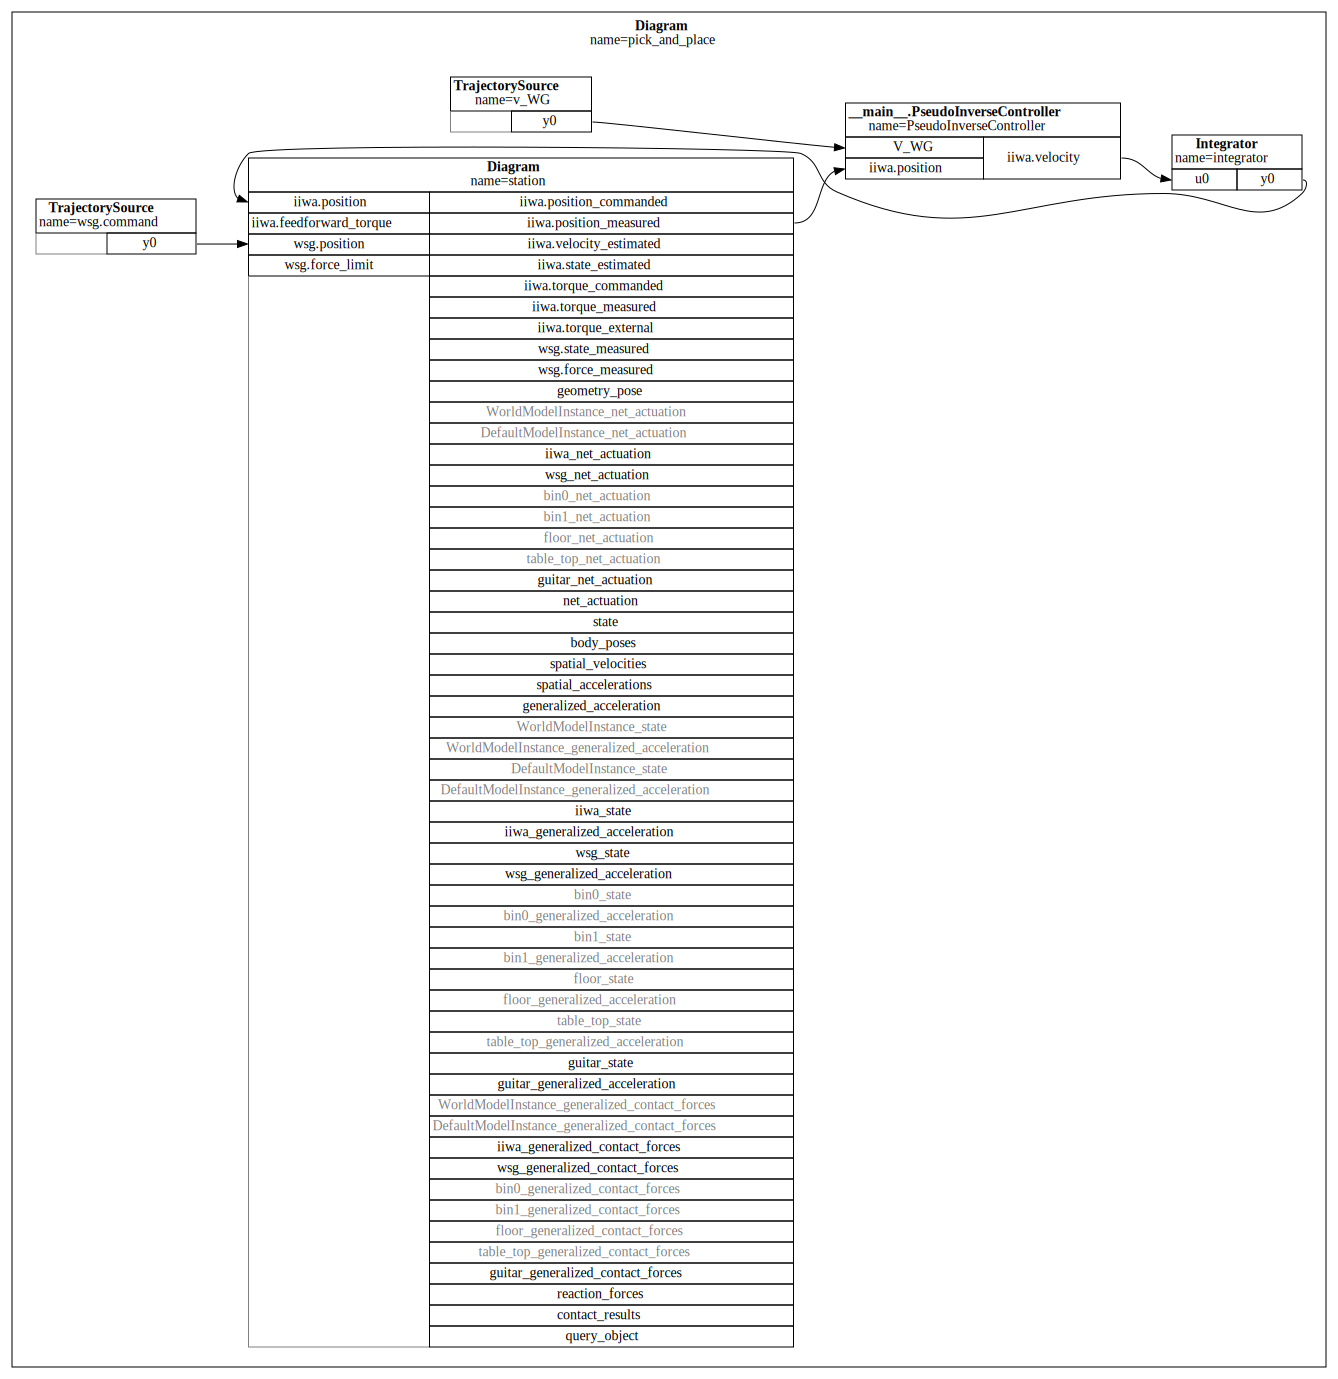

In [ ]:
RenderDiagram(diagram, max_depth=1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=df10144e-981b-4bcc-8f1f-bfdbe929934e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>